# 경진대회 이해

## 개요
- 경진대회명 : 항공 사진 내 선인장 식별 경진대회 [링크](https://www.kaggle.com/c/aerial-cactus-identification)
- 배경 : 
    - 기후 변화 때문에 자연이 지속적으로 파괴되는 상황에서, 자연을 보고하고자 멕시코에서 VIGIA라는 프로젝트 진행
    - VIGIA는, '자연보호 구역 자율 감시'를 위한 자동 시스템 개발 프로젝트
    - 자율 감시를 위해 첫 단계가 보호 구역 내에 초목이 잘 자라는지 확인 하는 작업.
    - 드론과 이미지 인식 기술 활용, 항공 사진을 찍고, 그 안에 초목 상태 확인
- 문제 유형 : 이진 분류
- 평가 지표 : ROC AUC
- 제출 시 사용 모델 : CNN
- 데이터
    - train.zip : 훈련 이미지 데이터 
    - test.zip : 테스트 이미지 데이터
    - train.csv : 훈련 이미지 데이터 파일 명 및 타깃값(0 or 1, 1은 선인장이 있다.)
    - sample_submission.csv : 샘플 제출 파일
- 미션 : 항공 사진 내 선인장이 있을 확률 예측

# 탐색적 데이터 분석

## 데이터 둘러보기

In [2]:
import pandas as pd

data_path = '/home/restful3/datasets_local/aerial-cactus-identification/'

labels = pd.read_csv(data_path+'train.csv')
submission = pd.read_csv(data_path+'sample_submission.csv')

In [3]:
# id - 파일 이름
# has_cactus : 선인장 유무 (1이 있음)
labels.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [4]:
submission.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


## 데이터 시각화

### 타깃값 분포

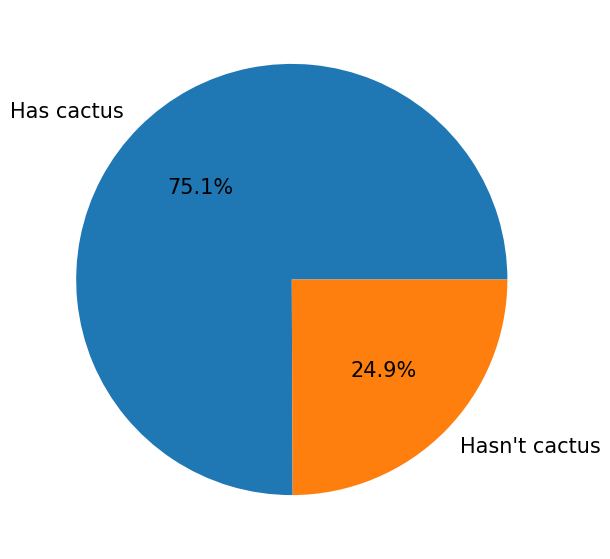

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('font', size=15)
plt.figure(figsize=(7, 7))

label = ['Has cactus', 'Hasn\'t cactus'] # target label

# 3:1 정도로, 선인장이 있는 경우가 더 많다.
plt.pie(labels['has_cactus'].value_counts(), labels = label, autopct='%.1f%%');

### 이미지 출력

In [8]:
import os

num_train = len(os.listdir(data_path+'train/'))
num_test = len(os.listdir(data_path+'test/'))

print(f'훈련 데이터 개수 : {num_train}')
print(f'테스트 데이터 개수 : {num_test}')

훈련 데이터 개수 : 17500
테스트 데이터 개수 : 4000


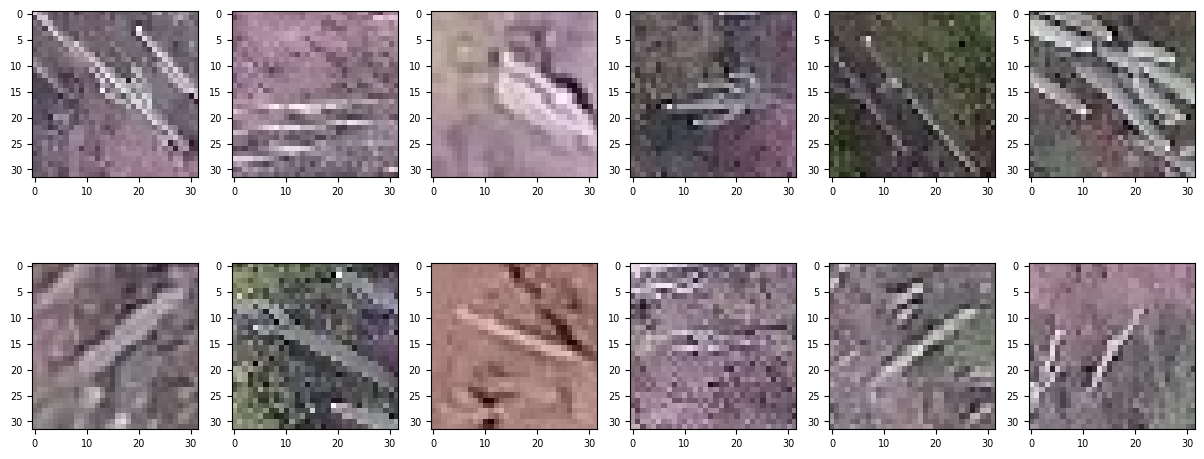

In [14]:
import matplotlib.gridspec as gridspec
import cv2

mpl.rc('font', size=7)
plt.figure(figsize=(15, 6)) # 전체 figure 크기
grid = gridspec.GridSpec(2, 6) # 서브플롯 배치 2행 6열

# 선인장 포함 이미지 파일명(마지막 12개)
last_has_cactus_img_name = labels[labels['has_cactus']==1]['id'][-12:]

for idx, img_name in enumerate(last_has_cactus_img_name):
    img_path = data_path + 'train/' + img_name # 이미지 파일 경로
    image = cv2.imread(img_path) # 파일 읽기
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # cv2는 기본이 BGR 이를 RGB로 변경
    ax = plt.subplot(grid[idx])
    ax.imshow(image)

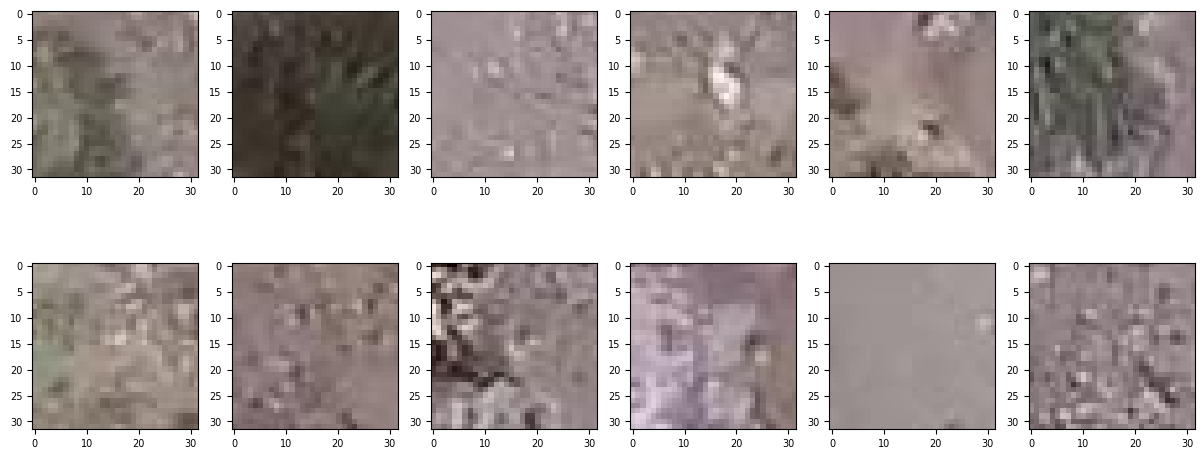

In [15]:
import matplotlib.gridspec as gridspec
import cv2

mpl.rc('font', size=7)
plt.figure(figsize=(15, 6))
grid = gridspec.GridSpec(2, 6)

last_hasnt_cactus_img_name = labels[labels['has_cactus']==0]['id'][-12:] # 선인장을 포함하지 않는 파일들 마지막 12개

for idx, img_name in enumerate(last_hasnt_cactus_img_name):
    img_path = data_path + 'train/' + img_name
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(grid[idx])
    ax.imshow(image)

In [16]:
# 32x32 크기의 낮은 해상도
image.shape

(32, 32, 3)

# 분석 정리 및 모델링 전략

## 분석 정리
- csv 파일의 id 피처는 이미지 파일명,
- 제공된 이미지 파일들은 낮은 해상도(32x32x3) 컬러 이미지

## 모델링 전략
- 베이스라인 모델 : 얕은 CNN
    - 신경망 구조 : 합성곱 x2, 폴링, 평탄화, 전결합
    - 옵티마이저 : SGD
- 성능 개선 : 살짝 깊은 CNN
    - 데이터 증강 : 다양한 변환기 사용
    - 신경망 구조 : 합성곱x5, 배치 정규화, 폴링, 평탄화, 전결합 x2
    - 옵티마이저 : Adam
    - 기타 : 훈련 에폭수 증가

# 베이스라인 모델

## 시드값 고정 및 GPU 장비 설정

### 시드값 고정

In [18]:
import torch
import random
import numpy as np
import os

# 여러가지 시드값 고정
seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed) # 파이썬 난수 생성기 시드 고정
np.random.seed(seed) # 넘파이 난수 생성기 시드 고정
torch.manual_seed(seed) # 파이토치 난수 생성기 시드 고정 (CPU사용시)
torch.cuda.manual_seed(seed) # 파이토치 난수 생성기 시드 고정 (GPU사용시)
torch.cuda.manual_seed_all(seed) # 파이토치 난수 생성기 시드 고정 (멀티 GPU사용시)
torch.backends.cudnn.deterministic=True # 확정적 연산 사용
torch.backends.cudnn.benchmark = False # 벤치마크 기능 해제
torch.backends.cudnn.enabled=False # cudnn 사용 해제

### GPU 장비 설정

In [19]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device    

device(type='cuda')

## 데이터 준비

<img src='../img/ch11_fig1.png'>

In [20]:
import pandas as pd

data_path = '/home/restful3/datasets_local/aerial-cactus-identification/'

labels = pd.read_csv(data_path+'train.csv')
submission = pd.read_csv(data_path+'sample_submission.csv')

### 훈련 데이터, 검증 데이터 분리

In [23]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(labels, test_size=0.1, stratify=labels['has_cactus'], random_state=50)

In [24]:
print(f'훈련 데이터 개수 : {len(train)}')
print(f'검증 데이터 개수 : {len(valid)}')

훈련 데이터 개수 : 15750
검증 데이터 개수 : 1750


### 데이터셋 클래스 정의

In [40]:
import cv2
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    # 생성자
    def __init__(self, df, img_dir='./', transform=None):
        super().__init__() # 상속 받은 Dataset 클래스의 생성자 호출
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        
    # 데이터셋 크기 변환 메서드
    def __len__(self):
        return len(self.df)
    
    # 인덱스에 해당하는 데이터 변환 메서드
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0] # 이미지 id
        img_path = self.img_dir + img_id # 이미지 파일 경로
        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB) # 파일 열어서 색상 보정
        label = self.df.iloc[idx, 1] # 이미지 레이블
        
        if self.transform is not None:
            image = self.transform(image) # 변환기가 있다면 변환
        return image, label

### 데이터셋 생성

In [41]:
from torchvision import transforms # 이미지 변환을 위한 모듈

transform = transforms.ToTensor() # 이미지를 텐서로 변환 32x32x3 --> 3x32x32

In [42]:
# train, valid 별 따로 변환기 만들어 줌 (뒤에 test 용도 만듦)
dataset_train = ImageDataset(df=train, img_dir=data_path+'train/', transform=transform)
dataset_valid = ImageDataset(df=valid, img_dir=data_path+'train/', transform=transform)

### 데이터 로더 생성

In [43]:
from torch.utils.data import DataLoader # 데이터 로더 클래스

# dataset : 앞서 만든 이미지 데이터셋
# batch_size : 배치 크기
# shuffle : valid, test는 False 임에 주의
# num_workers : 주어신 cpu의 코어수에 맞춰 설정, 클 수록 빨리 불러옴
loader_train = DataLoader(dataset=dataset_train, batch_size=32, shuffle=True, num_workers=8)
loader_valid = DataLoader(dataset=dataset_valid, batch_size=32, shuffle=False, num_workers=8)

## 모델 생성

<img src='../img/ch11_fig2.png'>

In [2]:
import torch.nn as nn # 신경망 모듈
import torch.nn.functional as F # 신경망 모듈에서 자주 사용되는 함수 모음

<img src='../img/ch11_fig3.png'>
<img src='../img/ch11_fig4.png'>

In [45]:
class Model(nn.Module):
    # 신경망 계층 정의
    def __init__(self):
        super().__init__() # 상속받은 nn.Module의 생성자 호출
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)
        self.max_pool = nn.MaxPool2d(kernel_size=2)
        self.avg_pool = nn.AvgPool2d(kernel_size=2)
        self.fc = nn.Linear(in_features=64*4*4, out_features =2)
        
    def forward(self, x):
        x = self.max_pool(F.relu(self.conv1(x)))
        x = self.max_pool(F.relu(self.conv2(x)))        
        x = self.avg_pool(x)
        x = x.view(-1, 64*4*4) # 평탄화, 32를 3번 반으로 나눔 (2^3 = 8, 4*8 = 32)
        x = self.fc(x)
        return x

In [46]:
model = Model().to(device)

### Model 클래스를 정의하는 또 다른 방법

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2),
                                   nn.ReLU(), nn.MaxPool2d(kernel_size=2))
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2),
                                   nn.ReLU(), nn.MaxPool2d(kernel_size=2))  
        self.avg_pool = nn.AvgPool2d(kernel_size=2)
        self.fc = nn.Linear(in_features=64*4*4, out_features =2)     
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avg_pool(x)
        x = x.view(-1, 64*4*4)
        x = self.fc(x)
        return x        

## 모델 훈련

### 손실 함수 설정
- 신경망 모델 훈련은 가중치를 갱신하는 작업
- 가중치 갱신은, 예측값과 실젯값의 손실이 작아지는 방향으로 이루어짐
- 손실값을 구하는 함수가 손실 함수 임
- [교차 엔트로피(Cross Entropy)](https://yeong-jin-data-blog.tistory.com/entry/%EA%B5%90%EC%B0%A8-%EC%97%94%ED%8A%B8%EB%A1%9C%ED%94%BCCross-Entropy#:~:text=%E2%9C%85%20%EA%B5%90%EC%B0%A8%20%EC%97%94%ED%8A%B8%EB%A1%9C%ED%94%BC&text=%EC%A0%95%EC%9D%98%20%3A%20%EC%97%94%ED%8A%B8%EB%A1%9C%ED%94%BC%EB%8A%94%20%ED%95%98%EB%82%98%EC%9D%98,%EB%93%A4%EC%9D%98%20%EC%B0%A8%EC%9D%B4%EB%A5%BC%20%EC%9D%98%EB%AF%B8%ED%95%A8.)
- [Binary Cross Entropy 와 Cross Entropy 의 차이](https://wooono.tistory.com/387)

In [47]:
criterion = nn.CrossEntropyLoss()

### 옵티마이저 설정
- 옵티마이저는 최적 가중치를 찾아주는 알고리즘
- SGD는, 경사 하강법을 이용한 기본 옵티마이저

In [48]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

### 모델 훈련

In [49]:
epochs = 10 # 총 에폭

# 총 에폭만큼 반복
for epoch in range(epochs):
    epoch_loss = 0 # 에폭 별 손실값 초기화
    
    # 반복 횟수 만큼 반복
    for images, labels in loader_train:
        # 이미지, 레이블를 device에 적용 (CPU OR GPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실 함수를 활용, outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가
        epoch_loss += loss.item()
        # 역전파 수행
        loss.backward()

        # 가중치 갱신 : 기존 가중치 - (학습률x기울기)
        optimizer.step()
    # 훈련 데이터 손실값 출력
    print(f'에폭 [{epoch+1}/{epochs}] -  손실값 : {epoch_loss/len(loader_train):.4f}')

에폭 [1/10] -  손실값 : 0.5271
에폭 [2/10] -  손실값 : 0.3634
에폭 [3/10] -  손실값 : 0.2510
에폭 [4/10] -  손실값 : 0.1949
에폭 [5/10] -  손실값 : 0.1747
에폭 [6/10] -  손실값 : 0.1584
에폭 [7/10] -  손실값 : 0.1463
에폭 [8/10] -  손실값 : 0.1422
에폭 [9/10] -  손실값 : 0.1306
에폭 [10/10] -  손실값 : 0.1269


### 에폭 vs. 배치 크기 vs. 반복 횟수

<img src="../img/ch11_fig5.png">

- 에폭 : 훈련 데이터 전체를 한번 훑었음
- 배치 크기 : 매 훈련 이터레이션에서 한 번에 훈련할 데이터 개수
- 반복 횟수 : 1 에폭의 훈련을 완료하기 위해 필요한 훈련 이터레이션, 훈련 데이터 개수 / 배치 크기

## 성능 검증

In [57]:
from sklearn.metrics import roc_auc_score

true_list = []
preds_list = []

In [58]:
# 모델을 평가 상태로 설정
model.eval()

with torch.no_grad(): # 기울기 계산 비활성화
    for images, labels in loader_valid:
        images = images.to(device)
        labels = labels.to(device)
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        preds = torch.softmax(outputs.cpu(), dim=1)[:, 1] # 예측 확률
        true = labels.cpu() # 계산을 하기 위해 CPU로 설정
        preds_list += preds # 예측값
        true_list += true # 실젯값

# 검증 데이터 ROC AUC 점수 계산
print(f'검증 데이터 roc auc : {roc_auc_score(true_list, preds_list):.4f}')

검증 데이터 roc auc : 0.9896


## 예측 및 결과 제출

In [59]:
dataset_test = ImageDataset(df=submission, img_dir=data_path+'test/', transform=transform)
loader_test = DataLoader(dataset=dataset_test, batch_size=32, shuffle=False)

### 예측

In [66]:
# 모델을 평가 상태로 설정
model.eval()

preds = []

with torch.no_grad(): # 기울기 계산 비활성화
    for images, _ in loader_test:
        images = images.to(device)
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        preds_part = torch.softmax(outputs.cpu(), dim=1)[:, 1].tolist() # 예측 확률, tolist : 텐서를 리스트 타입으로
        preds += preds_part

In [68]:
submission['has_cactus'] = preds
submission.to_csv('submission_1.csv', index=False)

### 결과 제출

# 성능 개선
- 다양한 이미지 변환 수행 
- 더 깊은 CNN 모델 
- 더 뛰어난 옵티마이저 사용
- 훈련 시 에폭 수 늘림

<img src='../img/ch11_fig6.png'>

## 데이터 준비

In [26]:
import torch
import random
import numpy as np
import os

seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.enabled=False

In [27]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device    

device(type='cuda')

In [54]:
import pandas as pd

data_path = '/home/restful3/datasets_local/aerial-cactus-identification/'

labels = pd.read_csv(data_path+'train.csv')
submission = pd.read_csv(data_path+'sample_submission.csv')

In [55]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(labels, test_size=0.1, stratify=labels['has_cactus'], random_state=50)

### 이미지 변환과 데이터 증강

- Compose() : 여러 변환기를 묶음
- ToTensor() : PIL 이미지나 ndarray를 텐서로 변환
- Pad() : 이미지 주변에 패딩 추가
- RandomHorizontalFlip() : 이미지를 무작위로 좌우 대칭 변환
- RandomVerticalFlip() : 상하 대칭 변환
- RandomRotation() : 이미지를 무작위로 회전
- Normalize() : 텐서 형태의 이미지 데이터를 정규화

### 이미지 변환기 정의

<img src='../img/ch11_fig7.png'>

In [30]:
from torchvision import transforms # 이미지 변환을 위한 모듈

transform_train = transforms.Compose(
    [transforms.ToTensor(), # 이미지를 텐서 객체로
    transforms.Pad(32, padding_mode='symmetric'), # 이미지 주변에 패팅, 32x32 --> 96x96
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Normalize((0.485, 0.456, 0.486), 
                         (0.229, 0.224, 0.225))] #imagenet의 데이터들을 기반으로 정규화를 위한 기준 값 추출
)

transform_test = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Pad(32, padding_mode='symmetric'),
    transforms.Normalize((0.485, 0.456, 0.486), 
                         (0.229, 0.224, 0.225))]
)

### 데이터셋 및 데이터 로더 생성

In [65]:
import cv2
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    def __init__(self, df, img_dir='./', transform=None):
        super().__init__()
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]
        img_path = self.img_dir + img_id
        image = cv2.imread(img_path)
#         print(img_path, image.shape)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.df.iloc[idx, 1]
        
        if self.transform is not None:
            image = self.transform(image)
        return image, label
        

In [66]:
dataset_train = ImageDataset(df=train, img_dir=data_path+'train/',
                            transform=transform_train)
dataset_valid = ImageDataset(df=valid, img_dir=data_path+'train/',
                            transform=transform_test)

In [67]:
from torch.utils.data import DataLoader

loader_train = DataLoader(dataset=dataset_train, batch_size=32, shuffle=True)
loader_valid = DataLoader(dataset=dataset_valid, batch_size=32, shuffle=False)

## 모델 생성

<img src='../img/ch11_fig8.png'>

In [68]:
import torch.nn as nn #신경망 모듈
import torch.nn.functional as F #유용한 함수 모음

class Model(nn.Module):
    # 신경망 계층 정의
    def __init__(self):
        super().__init__() # nn.Module의 생성자
        # 1~5번째 레이어 (합성곱, 배치 정규화, 최대 풀링)
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, 
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(32),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, 
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(64),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))

        self.layer3 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, 
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(128),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
 

        self.layer4 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, 
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(256),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))

        self.layer5 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512, 
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(512),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        
        
        self.avg_pool = nn.AvgPool2d(kernel_size=4)
        
        self.fc1 = nn.Linear(in_features=512*1*1, out_features = 64)     
        self.fc2 = nn.Linear(in_features=64, out_features = 2)             
    
    # 순전파 출력 정의
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avg_pool(x)
        x = x.view(-1, 512*1*1) # 평탄화 96 -> 49 -> 25 -> 13 -> 7 -> 4 -> 1
        x = self.fc1(x)
        x = self.fc2(x)        
        return x        

In [69]:
model = Model().to(device)

## 모델 훈련

### 손실 함수와 옵티마어저 설정

In [70]:
criterion = nn.CrossEntropyLoss()

In [71]:
# Adam의 개량형
optimizer = torch.optim.Adamax(model.parameters(), lr=0.00006)

### 모델 훈련

In [73]:
epochs = 70

for epoch in range(epochs):
    epoch_loss = 0
    
    for images, labels in loader_train:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f'에폭 [{epoch+1}/{epochs}] -  손실값 : {epoch_loss/len(loader_train):.4f}')     

에폭 [1/70] -  손실값 : 0.0235
에폭 [2/70] -  손실값 : 0.0225
에폭 [3/70] -  손실값 : 0.0216
에폭 [4/70] -  손실값 : 0.0182
에폭 [5/70] -  손실값 : 0.0181
에폭 [6/70] -  손실값 : 0.0169
에폭 [7/70] -  손실값 : 0.0181
에폭 [8/70] -  손실값 : 0.0159
에폭 [9/70] -  손실값 : 0.0148
에폭 [10/70] -  손실값 : 0.0136
에폭 [11/70] -  손실값 : 0.0155
에폭 [12/70] -  손실값 : 0.0131
에폭 [13/70] -  손실값 : 0.0145
에폭 [14/70] -  손실값 : 0.0112
에폭 [15/70] -  손실값 : 0.0126
에폭 [16/70] -  손실값 : 0.0119
에폭 [17/70] -  손실값 : 0.0116
에폭 [18/70] -  손실값 : 0.0115
에폭 [19/70] -  손실값 : 0.0098
에폭 [20/70] -  손실값 : 0.0105
에폭 [21/70] -  손실값 : 0.0095
에폭 [22/70] -  손실값 : 0.0098
에폭 [23/70] -  손실값 : 0.0084
에폭 [24/70] -  손실값 : 0.0094
에폭 [25/70] -  손실값 : 0.0081
에폭 [26/70] -  손실값 : 0.0092
에폭 [27/70] -  손실값 : 0.0085
에폭 [28/70] -  손실값 : 0.0087
에폭 [29/70] -  손실값 : 0.0089
에폭 [30/70] -  손실값 : 0.0077
에폭 [31/70] -  손실값 : 0.0081
에폭 [32/70] -  손실값 : 0.0077
에폭 [33/70] -  손실값 : 0.0061
에폭 [34/70] -  손실값 : 0.0079
에폭 [35/70] -  손실값 : 0.0069
에폭 [36/70] -  손실값 : 0.0076
에폭 [37/70] -  손실값 : 0.0068
에폭 [38/70]

## 성능 검증

In [74]:
from sklearn.metrics import roc_auc_score

true_list = []
preds_list = []

model.eval()

with torch.no_grad():
    for images, labels in loader_valid:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        preds = torch.softmax(outputs.cpu(), dim=1)[:, 1]
        true = labels.cpu()
        preds_list.extend(preds)
        true_list.extend(true)
        
print(f'검증 데이터 roc auc : {roc_auc_score(true_list, preds_list):.4f}')        

검증 데이터 roc auc : 0.9999


## 예측 및 결과 제출

In [77]:
dataset_test = ImageDataset(df=submission, img_dir=data_path+'test/', transform=transform_test)
loader_test = DataLoader(dataset=dataset_test, batch_size=32, shuffle=False)

In [78]:
model.eval()

preds = []

with torch.no_grad():
    for images, _ in loader_test:
        images = images.to(device)
        
        outputs = model(images)
        preds_part = torch.softmax(outputs.cpu(), dim=1)[:, 1].tolist()
        preds += preds_part

In [79]:
submission['has_cactus'] = preds
submission.to_csv('submission_2.csv', index=False)

### 한 걸음 더

- 훈련 데이터를, 검증용으로 분할 하지 말고 전체를 다 사용하여 학습 하게 되면 성능이 개선 된다.

### 요약
- 딥러닝 모델은 매번 같은 값을 가지려면 시드값을 여러곳 고정을 해야 한다.
- GPU를 활용은 필수
- 파이토치는 데이터 셋과 데이터 로더가 필요하다.
- transforms 모듈로 원본 이미지를 특정한 형태로 변화 시킨다. (데이터 증강)
- 손실 함수는 예측값과 실젯값의 차이를 구하는 함수
- CNN은 이미지 인식에 주로 사용
- 활성화 함수는 입력값을 어떤 값으로 변환해 출력할지 결정, ReLU 를 많이 사용
- 옵티마이저는 최적 가중치를 찾아주는 함수, SGD, Adam, RMSProp 등을 많이 사용
- 에폭은 '훈련 데이터 전체'를 한번 훑었음을, 배치 크기는 매 훈련 이터레이션에서 한 번에 훈련할 데이터의 개수, 반복 횟수는 1 에폭의 훈련을 완료하는데 필요한 훈련 이터레이션의 수
- 배치 정규화는 계층 간 데이터 분포의 편차를 줄이는 작업, 신경망 레이어마다 입력 데이터 분포가 다르면, 훈련 속도가 느려지고 과대적합 가능